In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from tang_jcompneuro.model_fitting_postprocess import load_data_generic

In [3]:
mlp_k_list = (4,  # so that we have roughly 144 units.
              20, 40, 60, 80, 100, 120,
              145,  # > 95% variance preserved.
            # check
            # https://github.com/leelabcnbc/tang_jcompneuro_revision/blob/master/results_ipynb/debug/cnn/cnn_wrapper.ipynb
              )

def from_k_to_num_unit(k):
    return  882 // (k + 2)

def from_k_to_num_param(k):
    num_unit = from_k_to_num_unit(k)
    return num_unit*(k+1) + (num_unit+1)

In [4]:
def print_mlp_stats():
    for k in mlp_k_list:
        print(k, from_k_to_num_unit(k), from_k_to_num_param(k))
print_mlp_stats()

4 147 883
20 40 881
40 21 883
60 14 869
80 10 821
100 8 817
120 7 855
145 6 883


In [5]:
def modelname_alternative(_1, x, _2, _3):
    if x.startswith('mlp.'):
        _, k = x.split('.')
        assert _ == 'mlp'
        k = int(k)
        num_unit = from_k_to_num_unit(k)
        return num_unit
    else:
        assert x == 'b.9_avg'
        return 10000  # so that it's the largest; just a hack.

In [6]:
def check_all(squared, score_col_name):
    models_to_examine = [
        ('cnn', 'b.9_avg'),
    ] + [('cnn', f'mlp.{k}') for k in mlp_k_list]
    
    
    return load_data_generic(models_to_examine, load_naive=False, metric='ccnorm_5', squared=squared,
                            score_col_name=score_col_name, modelname_alternative=modelname_alternative)


In [7]:
df_all_cc2 = check_all(squared=True, score_col_name='cc2').xs(100, level='percentage').sort_index()

MkA_Shape all
MkA_Shape OT
MkE2_Shape all
MkE2_Shape OT


In [8]:
HO_neuron_perf = df_all_cc2.apply(lambda x: x['cc2']['HO']['mean'], axis=1).unstack('subset')
HO_neuron_perf

subset                  OT       all
dataset    model                    
MkA_Shape  6      0.127780  0.270385
           7      0.132967  0.274719
           8      0.141153  0.276088
           10     0.139250  0.281893
           14     0.148617  0.292465
           21     0.162580  0.301699
           40     0.179152  0.304627
           147    0.118086  0.160400
           10000  0.250641  0.367786
MkE2_Shape 6      0.120949  0.271650
           7      0.130305  0.275440
           8      0.141526  0.276572
           10     0.144178  0.283305
           14     0.151898  0.290165
           21     0.168729  0.295684
           40     0.184651  0.293833
           147    0.106206  0.137575
           10000  0.252035  0.377163

In [9]:
OT_neuron_perf = df_all_cc2.apply(lambda x: x['cc2']['OT']['mean'], axis=1).unstack('subset')
OT_neuron_perf

subset                  OT       all
dataset    model                    
MkA_Shape  6      0.293143  0.383536
           7      0.299901  0.390689
           8      0.316155  0.389962
           10     0.318840  0.404567
           14     0.336597  0.415633
           21     0.352522  0.416966
           40     0.375387  0.407508
           147    0.235728  0.196111
           10000  0.499659  0.484823
MkE2_Shape 6      0.326542  0.427480
           7      0.347407  0.438807
           8      0.359441  0.437830
           10     0.372744  0.450317
           14     0.393184  0.462459
           21     0.420681  0.468485
           40     0.425298  0.453367
           147    0.249044  0.211170
           10000  0.538177  0.543661

In [10]:
from tang_jcompneuro.plotting import image_subset_and_neuron_subset_list, show_perf_vs_size
from tang_jcompneuro import dir_dictionary
import os.path

In [11]:
# time to plot.
# magic numbers here follow
# https://github.com/leelabcnbc/tang_jcompneuro/blob/master/thesis_plots/v1_fitting/results_glm_opt_detailed.ipynb
def draw_one_stuff(dataset):
    # draw one by one.
    
    num_panel = len(image_subset_and_neuron_subset_list)
    
    plt.close('all')
    fig, axes = plt.subplots(1, num_panel, sharex=True, sharey=True, squeeze=False,
                            figsize=(5.5,2.5))
    for idx, (ax, (img_subset, neuron_subset)) in enumerate(zip(axes.ravel(), image_subset_and_neuron_subset_list)):
        
        if neuron_subset == 'OT':
            data_y = OT_neuron_perf.loc[(dataset, ), img_subset].values[:-1]
            cnn_ref = OT_neuron_perf.loc[(dataset, ), img_subset].values[-1]
            data_x = OT_neuron_perf.loc[(dataset, ), img_subset].index.values[:-1]
            assert OT_neuron_perf.loc[(dataset, ), img_subset].index.values[-1] == 10000
        elif neuron_subset == 'HO':
            data_y = HO_neuron_perf.loc[(dataset, ), img_subset].values[:-1]
            cnn_ref = HO_neuron_perf.loc[(dataset, ), img_subset].values[-1]
            data_x = HO_neuron_perf.loc[(dataset, ), img_subset].index.values[:-1]
            assert HO_neuron_perf.loc[(dataset, ), img_subset].index.values[-1] == 10000
        else:
            raise NotImplementedError
        assert data_y.shape == (8,)
        data_x = data_x
        assert np.array_equal(data_x, np.sort(data_x))
        assert data_x.shape == data_y.shape == (data_x.size,)
        #print(data_x)
        # color
        # https://matplotlib.org/users/dflt_style_changes.html#colors-color-cycles-and-color-maps
        show_perf_vs_size([data_x], [data_y], ['dummy'],
                          title=f'{neuron_subset} neurons\n{img_subset} stimuli',
                      ax=ax, xlabel='# of hidden units',
                      ylabel='mean $CC_\mathrm{norm}^2$' if idx == 0 else None,
                         style_list=[('-', '#1f77b4', 'x')], show_legend=False,
                         xlim=(0,150),
                          ylim=(0,1),
                         xticks=(0,50,100,
                                ),
                         xticklabels=('0', '50', '100',
#                                       '2k'
                                     ),
                         yticks=(0,0.5,1.0),
                         yticklabels=('0', '0.5', '1'),
                          # for baseline model
                         hline=cnn_ref,
                          vline=40,
#                           letter='h'
                         )
    mk = {'MkA_Shape': 'A', 'MkE2_Shape': 'B'}[dataset]
    fig.suptitle(f'MLP performance vs. # of hidden units on monkey {mk}')
    # adjust figure 
    fig.subplots_adjust(top=0.7, bottom=0.2, left=0.11, right=1, hspace=0.1, wspace=0.05)
    
    fig.text(0, 1, 'h', horizontalalignment='left', verticalalignment='top',
            transform=fig.transFigure, fontweight='bold')
    
    save_dir = os.path.join(dir_dictionary['plots'], 'main', 'mlp_model')
    os.makedirs(save_dir, exist_ok=True)
    fig.savefig(os.path.join(save_dir, f'{dataset}.pdf'), dpi=300)
    
    plt.show()

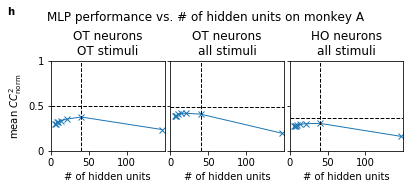

In [12]:
draw_one_stuff('MkA_Shape')

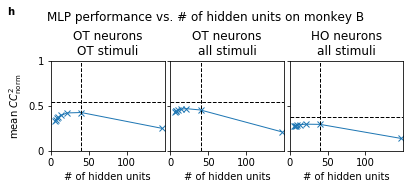

In [13]:
draw_one_stuff('MkE2_Shape')